In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Task1

#### Define Functions Ahead

In [16]:
def detect_chamber(committee_name):
    """This function helps to identify chamber based on committee name patterns with special cases"""
    name = str(committee_name).lower()
    
    # Standard patterns
    house_keywords = r'house|representatives|h\.r\.|hr\b'
    senate_keywords = r'senate|s\.r\.|sr\b|sen\.'
    
    if re.search(house_keywords, name):
        return 'House'
    elif re.search(senate_keywords, name):
        return 'Senate'
    elif 'joint' in name:
        return 'Joint'
    
    # Based on Online Congressional Guidance
    elif 'appropriations' in name and 'senate' not in name:
        return 'House'
    elif 'finance' in name:
        return 'Senate'
    elif 'foreign relations' in name:
        return 'Senate'
    elif 'foreign affairs' in name:
        return 'House'
    elif 'armed services' in name:
        return 'Senate' if 'senate' in name else 'House'
    elif 'ways and means' in name:
        return 'House'
    elif 'judiciary' in name:
        return 'House' if 'representatives' in name else 'Senate'
    else:
        return 'Unknown'

def plot_top_committees_by_chamber(chamber_name, color, top_n=10):
    """This function helps to plot top committees for a specific chamber with empty data handling"""
    chamber_data = committee_stats[committee_stats['chamber'] == chamber_name]
    
    if len(chamber_data) == 0:
        print(f"\nNo {chamber_name} committees found in the data.")
        return pd.DataFrame()  
    
    top_data = chamber_data.sort_values('importance_score', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=top_data, y='committee_name', x='importance_score', 
                    color=color, edgecolor='black')
    
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 0.02, p.get_y() + p.get_height()/2., 
               f'{width:.2f}', ha='left', va='center')
    
    plt.title(f'Top {top_n} {chamber_name} Committees by Importance', fontsize=14)
    plt.xlabel('Importance Score (0-1 scale)', fontsize=12)
    plt.ylabel('')
    plt.xlim(0, 1.1)
    plt.grid(axis='x', alpha=0.2)
    plt.tight_layout()
    plt.savefig(f'top_{chamber_name.lower()}_committees.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return top_data[['committee_name', 'importance_score', 'total_bills', 'total_lobbying_dollars']]

#### Data Cleaning & Manipulation

In [17]:
print("Loading data...")
committees = pd.read_csv('committees.csv')
bills_committees = pd.read_csv('bills_committees.csv')
filings = pd.read_csv('filings.csv')
filings_bills = pd.read_csv('filings_bills.csv')

print("Detecting chambers...")
committees['chamber'] = committees['committee_name'].apply(detect_chamber)

print("Cleaning financial data...")
filings['amount_clean'] = filings['amount'].apply(
    lambda x: float(str(x).replace('$', '').replace(',', '')) if pd.notna(x) else 0.0)

print("Merging datasets...")
committee_analysis = pd.merge(
    pd.merge(
        bills_committees,
        committees[['committee_id', 'committee_name', 'chamber']],
        on='committee_id',
        how='left'
    ),
    pd.merge(
        filings_bills,
        filings[['filing_uuid', 'amount_clean']],
        on='filing_uuid',
        how='left'
    ),
    left_on='bill_id',
    right_on='bill_id',
    how='left'
)

print("Calculating committee statistics...")
committee_stats = committee_analysis.groupby(
    ['committee_id', 'committee_name', 'chamber']
).agg(
    total_bills=('bill_id', 'nunique'),
    total_lobbying_dollars=('amount_clean', 'sum'),
    lobbying_reports=('filing_uuid', 'nunique')
).reset_index()

print("Normalizing metrics...")
for chamber in ['House', 'Senate', 'Joint']:
    chamber_mask = committee_stats['chamber'] == chamber
    for col in ['total_bills', 'total_lobbying_dollars', 'lobbying_reports']:
        col_max = committee_stats.loc[chamber_mask, col].max()
        if col_max > 0:
            committee_stats.loc[chamber_mask, f'{col}_norm'] = (
                committee_stats.loc[chamber_mask, col] / col_max
            )
        else:
            committee_stats.loc[chamber_mask, f'{col}_norm'] = 0

committee_stats['importance_score'] = committee_stats[
    ['total_bills_norm', 'total_lobbying_dollars_norm', 'lobbying_reports_norm']
].mean(axis=1)

Loading data...
Detecting chambers...
Cleaning financial data...
Merging datasets...
Calculating committee statistics...
Normalizing metrics...


#### Result Generation

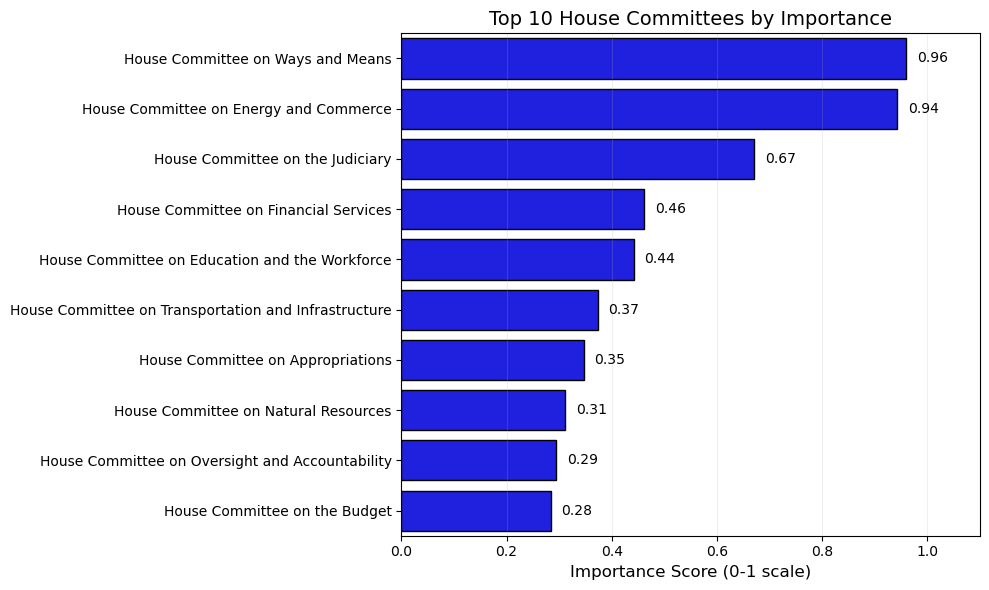

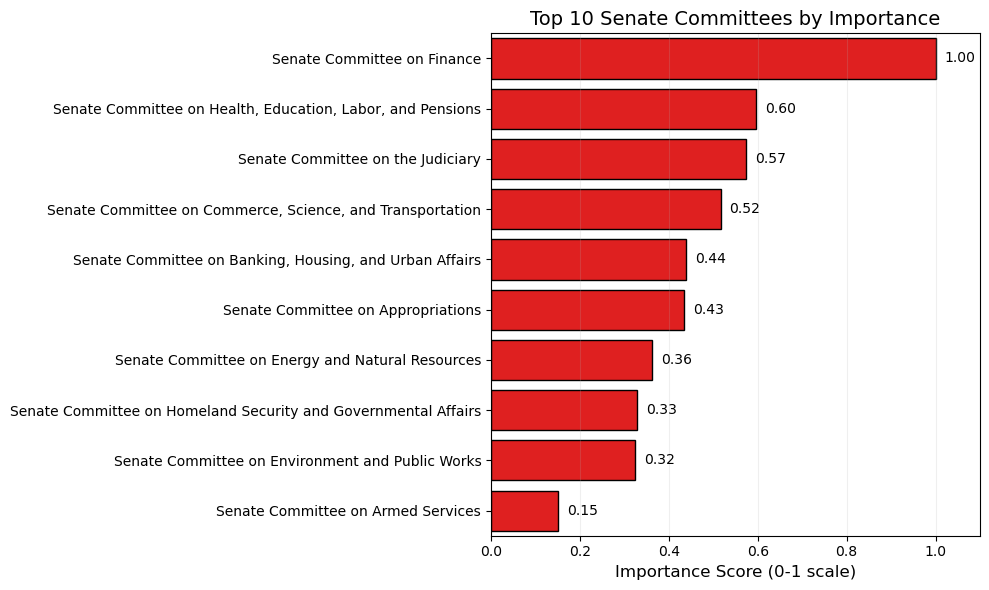


No Joint committees found in the data.


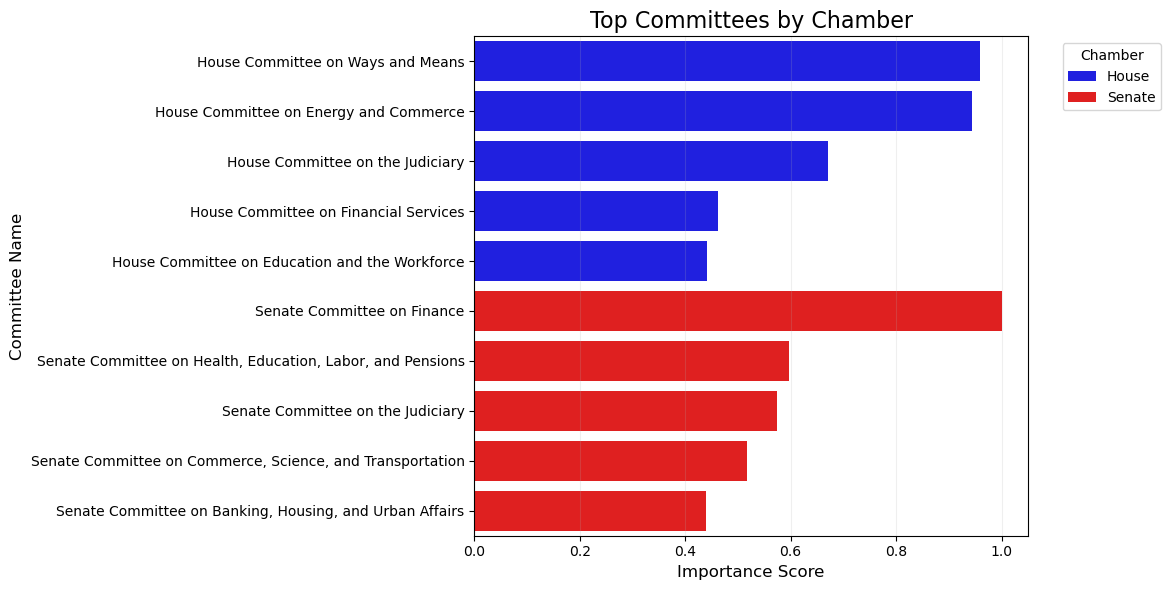

In [18]:
house_top = plot_top_committees_by_chamber('House', 'blue')
senate_top = plot_top_committees_by_chamber('Senate', 'red') 
joint_top = plot_top_committees_by_chamber('Joint', 'purple')

chambers_to_compare = []
if len(house_top) > 0:
    chambers_to_compare.append(house_top.head(5).assign(chamber='House'))
if len(senate_top) > 0:
    chambers_to_compare.append(senate_top.head(5).assign(chamber='Senate'))
if len(joint_top) > 0:
    chambers_to_compare.append(joint_top.head(3).assign(chamber='Joint'))

if chambers_to_compare:  
    top_combined = pd.concat(chambers_to_compare)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=top_combined, y='committee_name', x='importance_score',
                hue='chamber', dodge=False,
                palette={'House': 'blue', 'Senate': 'red', 'Joint': 'purple'})
    plt.title('Top Committees by Chamber', fontsize=16)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Committee Name', fontsize=12)
    plt.legend(title='Chamber', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='x', alpha=0.2)
    plt.tight_layout()
    plt.savefig('top_committees_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("\nNo committee data available for comparison.")

In [20]:
print("\n=== Top 5 House Committees ===")
print(house_top.head(5).to_markdown(index=False))
print("\n=== Top 5 Senate Committees ===")
print(senate_top.head(5).to_markdown(index=False))


=== Top 5 House Committees ===
| committee_name                                 |   importance_score |   total_bills |   total_lobbying_dollars |
|:-----------------------------------------------|-------------------:|--------------:|-------------------------:|
| House Committee on Ways and Means              |           0.959893 |          7340 |              1.51439e+10 |
| House Committee on Energy and Commerce         |           0.943021 |          6668 |              1.72153e+10 |
| House Committee on the Judiciary               |           0.67115  |          4659 |              1.2144e+10  |
| House Committee on Financial Services          |           0.461831 |          2552 |              1.04984e+10 |
| House Committee on Education and the Workforce |           0.441879 |          3252 |              6.46128e+09 |

=== Top 5 Senate Committees ===
| committee_name                                             |   importance_score |   total_bills |   total_lobbying_dollars |
|:-

## Task2

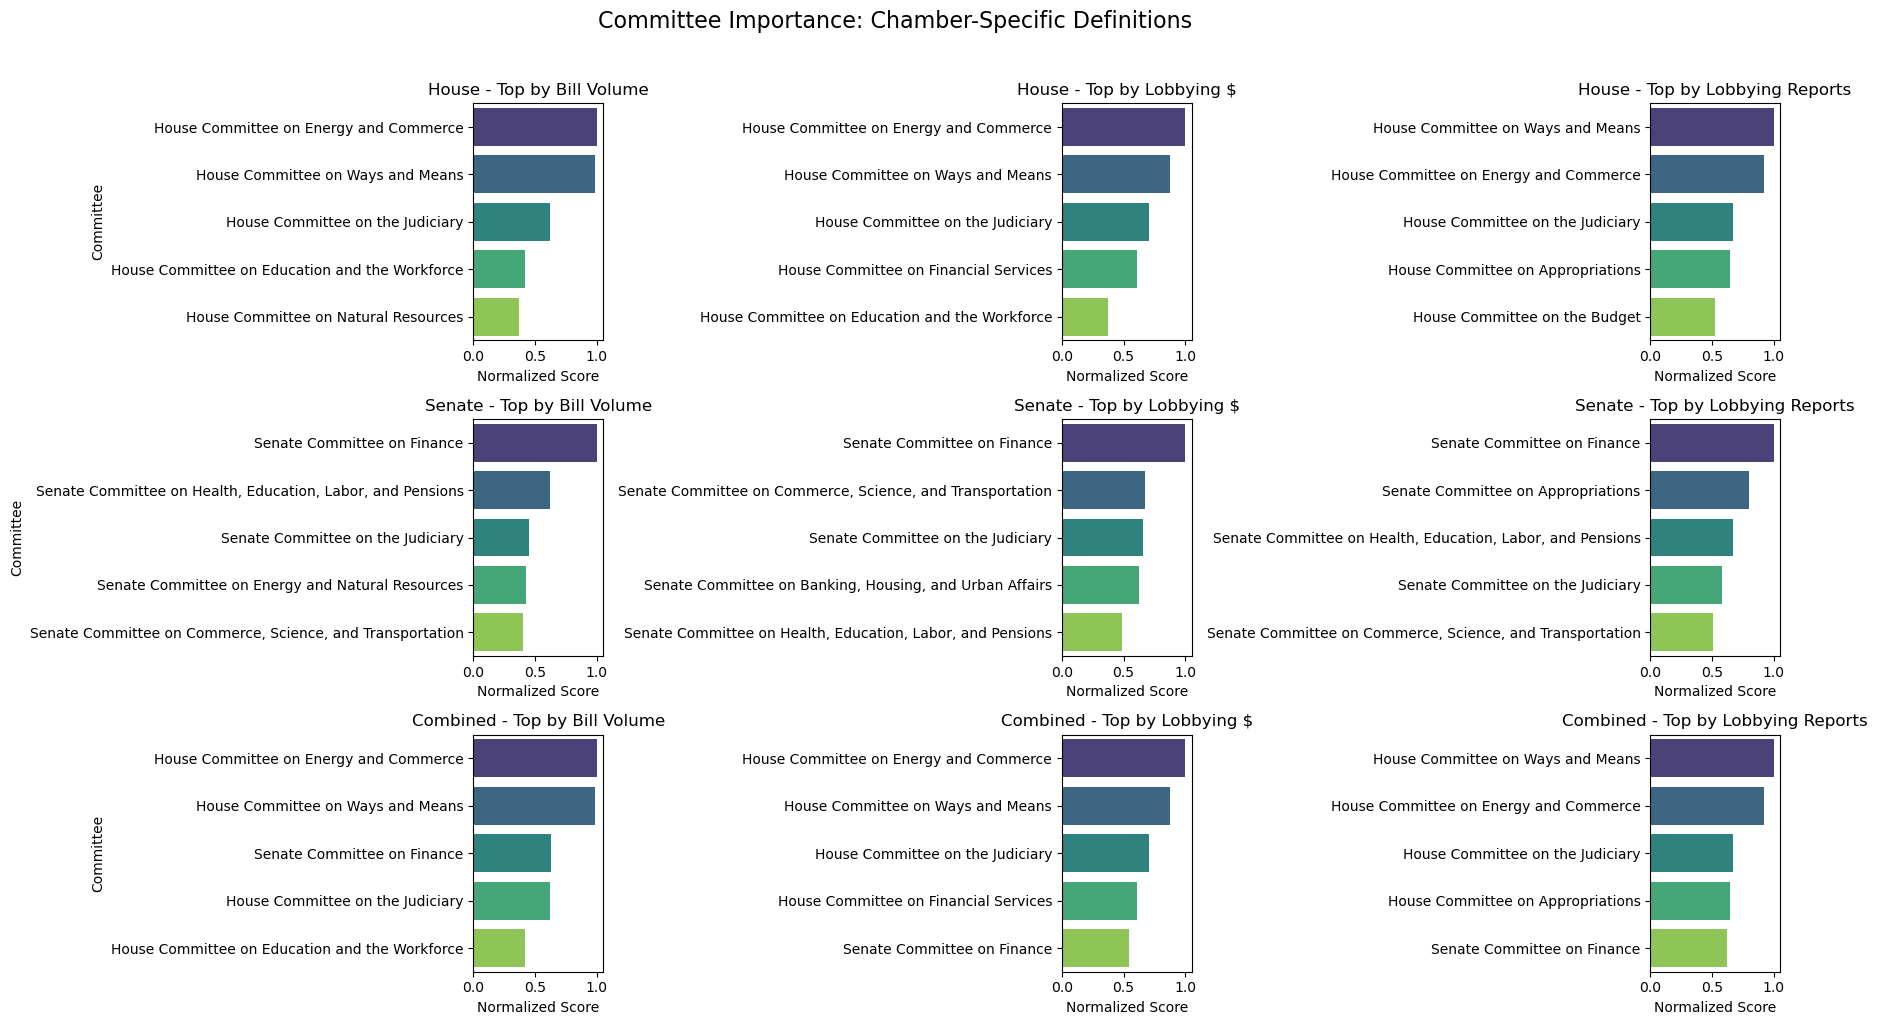

In [24]:
committees = pd.read_csv('committees.csv')
committees['chamber'] = committees['committee_name'].apply(detect_chamber)  # Your chamber detection function

committee_analysis = pd.merge(
    pd.merge(bills_committees, committees, on='committee_id'),
    pd.merge(filings_bills, filings[['filing_uuid', 'amount_clean']], on='filing_uuid'),
    left_on='bill_id', right_on='bill_id'
)

def calculate_metrics(df, chamber=None):
    if chamber:
        df = df[df['chamber'] == chamber]
    
    stats = df.groupby(['committee_id', 'committee_name']).agg(
        total_bills=('bill_id', 'nunique'),
        total_lobbying=('amount_clean', 'sum'),
        lobbying_reports=('filing_uuid', 'nunique')
    ).reset_index()
    
    for col in ['total_bills', 'total_lobbying', 'lobbying_reports']:
        stats[f'{col}_norm'] = stats[col] / stats[col].max()
    
    stats['chamber'] = chamber if chamber else 'Combined'
    return stats

house_stats = calculate_metrics(committee_analysis, 'House')
senate_stats = calculate_metrics(committee_analysis, 'Senate')
combined_stats = calculate_metrics(committee_analysis)

all_stats = pd.concat([house_stats, senate_stats, combined_stats])

plt.figure(figsize=(18, 10))
chambers = ['House', 'Senate', 'Combined']
metrics = ['total_bills_norm', 'total_lobbying_norm', 'lobbying_reports_norm']
metric_names = ['Bill Volume', 'Lobbying $', 'Lobbying Reports']

for i, chamber in enumerate(chambers, 1):
    for j, (metric, name) in enumerate(zip(metrics, metric_names), 1):
        plt.subplot(3, 3, (i-1)*3 + j)
        data = all_stats[all_stats['chamber'] == chamber].nlargest(5, metric)
        sns.barplot(data=data, y='committee_name', x=metric, palette='viridis')
        plt.title(f'{chamber} - Top by {name}')
        plt.xlabel('Normalized Score')
        plt.ylabel('Committee' if j == 1 else '')

plt.suptitle('Committee Importance: Chamber-Specific Definitions', y=1.02, fontsize=16)
plt.tight_layout()
plt.savefig('chamber_specific_definitions.png', dpi=300, bbox_inches='tight')
plt.show()